In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Input, Softmax, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras import models, layers, optimizers, regularizers, initializers
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output


In [8]:
BATCH_SIZE = 256
SEED = 23582068
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [9]:
dataset_path = "/home/jeff/Documents/Code/EvoSkeleton-master/examples/keypoints_normalized_clipped/"
jeff_val = "/home/jeff/Documents/Code/EvoSkeleton-master/examples/jeff_kpts_normalized_clipped/"
daniel_test = "/home/jeff/Documents/Code/EvoSkeleton-master/examples/daniel_kpts_normalized_clipped/"
val_datapath = daniel_test
test_datapath = jeff_val

partition = {
    "train": [],
    "val": [],
    "test": [],
}
labels = {}
classes = []
val_classes = []
good = 0 
ok = 0
bad = 0
test = False
for f in os.listdir(dataset_path):
    rand = random.random()
    # if (rand < 0.05):
        # test = True
        # partition["test"].append(f)
    # elif (rand > 0.1 and rand < 0.3):
    #     test = False
    #     partition["val"].append(f)
    # else:
        # test = False
    partition["train"].append(f)
    if ("ok") in f:
        labels[f] = 1
        ok += 1
    elif ("good") in f:
        labels[f] = 0
        good += 1
    elif ("bad") in f:
        labels[f] = 1
        bad += 1

for f in os.listdir(val_datapath):
    partition["val"].append(f)
    if ("ok") in f:
        labels[f] = 1
        # ok += 1
        val_classes.append(1)
    elif ("good") in f:
        labels[f] = 0
        # good += 1
        val_classes.append(0)
    elif ("bad") in f:
        labels[f] = 1
        # bad += 1
        val_classes.append(1)
    else:
        print("something went wrong!")

    # label is not being added because you haven't labelled test set with good, bad, ok, yet


for f in os.listdir(test_datapath):
    # print(f)
    partition["test"].append(f)
    if ("ok") in f:
        labels[f] = 1
        classes.append(1)
    elif ("good") in f:
        labels[f] = 0
        classes.append(0)
    elif ("bad") in f:
        labels[f] = 1
        classes.append(1)
print(good)
print(ok)
print(bad)
print(len(partition["train"]))
print(len(partition["val"]))
print(len(val_classes))
print(len(partition["test"]))
print(len(classes))
# print(len(labels))
# labels

# labels = to_categorical(labels)
# print(partition["test"])
labels

47258
48745
47499
143502
559
559
697
697


{'eddie_good0_scaled_kpts_3D_1989.npy': 0,
 'chris_ok_scaled_kpts_3D_486.npy': 1,
 'michael_ok_scaled_kpts_3D_513.npy': 1,
 'isaac_bad_scaled_kpts_3D_1629.npy': 1,
 'connor_bad_scaled_kpts_3D_3073.npy': 1,
 'amruthok1_scaled_kpts_3D_929.npy': 1,
 'chris_buff_3d_8177_ok.npy': 1,
 'isaac_bad_scaled_kpts_3D_627.npy': 1,
 'isaac_good_2_scaled_kpts_3D_3131.npy': 0,
 'daniel_bad_scaled_kpts_3D_1915.npy': 1,
 'isaac_ok_scaled_kpts_3D_4093.npy': 1,
 'connor_good_scaled_kpts_3D_599.npy': 0,
 'connor_good_scaled_kpts_3D_603.npy': 0,
 'isaac_ok_scaled_kpts_3D_3289.npy': 1,
 'isaac_good_2_scaled_kpts_3D_3808.npy': 0,
 'michael_bad_scaled_kpts_3D_1550.npy': 1,
 'chris_ok_scaled_kpts_3D_1182.npy': 1,
 'michael_ok_scaled_kpts_3D_1199.npy': 1,
 'amruthgood1_scaled_kpts_3D_1673.npy': 0,
 'connor_bad_scaled_kpts_3D_771.npy': 1,
 'connor_bad_scaled_kpts_3D_2474.npy': 1,
 'amruthgood1_scaled_kpts_3D_3390.npy': 0,
 'eddie_ok_scaled_kpts_3D_759.npy': 1,
 'eddie_bad0_scaled_kpts_3D_3431.npy': 1,
 'chris_good

In [6]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, dataset_dir, batch_size=64, dim=(17,3), n_classes=3, shuffle=True,):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.dataset_dir = dataset_dir
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
        # return len(self.list_IDs)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            f = np.load(self.dataset_dir + ID)
            # reshaped = f.reshape(-1,3,1)
            # X[i,] = reshaped
            X[i] = f

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [10]:
params = {
    'dim': (10,3),
    'n_classes': 2,
}

train_datagen = DataGenerator(
    partition["train"], 
    labels, 
    dataset_dir=dataset_path,
    batch_size=BATCH_SIZE,
    shuffle=True,
    **params
)
val_datagen = DataGenerator(
    partition["val"],
    labels,
    dataset_dir=val_datapath,
    batch_size=BATCH_SIZE,
    # batch_size=1,
    shuffle=True,
    **params
)
test_datagen = DataGenerator(
    partition["test"],
    labels,
    dataset_dir=test_datapath,
    # dataset_dir=jeff_val,
    shuffle=False,
    batch_size=1,
    **params
)
print(len(train_datagen))
print(len(val_datagen))
print(len(test_datagen))

560
2
697


In [11]:

kernel_rate = 0.005
bias_rate =   0.005
dropout_rate = 0.05
model = models.Sequential()

model.add(layers.InputLayer(input_shape=(10,3)))
model.add(
    layers.Dense(
        units=12, activation='relu',
        kernel_regularizer=regularizers.L1(kernel_rate),
        bias_regularizer=regularizers.L1(bias_rate),
    )
)
model.add(layers.Dropout(dropout_rate))
model.add(
    layers.Dense(
        units=12, activation='relu',
        kernel_regularizer=regularizers.L1(kernel_rate),
        bias_regularizer=regularizers.L1(bias_rate),
    )
)
model.add(layers.Dropout(dropout_rate))
model.add(
    layers.Dense(
        units=12, activation='relu',
        kernel_regularizer=regularizers.L1(kernel_rate),
        bias_regularizer=regularizers.L1(bias_rate),
    )
)
model.add(layers.Dropout(dropout_rate))
model.add(layers.Flatten())
model.add(layers.Dense(2, activation = 'softmax'))
model.summary()

# best performance: 3x12, 0.005 bias kernel 0.01 dropout 0.0008 lr

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10, 12)            48        
                                                                 
 dropout (Dropout)           (None, 10, 12)            0         
                                                                 
 dense_1 (Dense)             (None, 10, 12)            156       
                                                                 
 dropout_1 (Dropout)         (None, 10, 12)            0         
                                                                 
 dense_2 (Dense)             (None, 10, 12)            156       
                                                                 
 dropout_2 (Dropout)         (None, 10, 12)            0         
                                                                 
 flatten (Flatten)           (None, 120)               0

In [12]:
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [13]:

# from tensorflow.keras.callbacks import Callback
# import tensorflow.keras.backend as K
class SGDRScheduler(tf.keras.callbacks.Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        tf.keras.backend.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(tf.keras.backend.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

# lr_schedule = SGDRScheduler(min_lr=0.0008, max_lr=0.0063, steps_per_epoch=140, lr_decay=0.95, cycle_length=100)

In [9]:

# from tensorflow.keras.callbacks import Callback
# import tensorflow.keras.backend as K
class PlateauDestroyer(tf.keras.callbacks.Callback):
    def __init__(self,
                 og_lr,
                 steps_per_epoch,
                 epoch_to_jump_at,
                 number_of_high_epochs,
                 lr_new, lr_post):

        self.og_lr = og_lr
        self.steps_per_epoch = steps_per_epoch
        self.epoch_to_jump_at = epoch_to_jump_at
        self.number_of_high_epochs = number_of_high_epochs
        self.lr_new = lr_new
        self.lr_post = lr_post
        self.history = {}

    def on_train_begin(self, logs={}):
        logs = logs or {}
        tf.keras.backend.set_value(self.model.optimizer.lr, self.og_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(tf.keras.backend.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs={}):
        if (epoch+1 >= self.epoch_to_jump_at and epoch+1 <= self.epoch_to_jump_at + self.number_of_high_epochs):
            lr = self.lr_new
            # print(epoch+1, lr)
        elif (epoch+1 > self.epoch_to_jump_at + self.number_of_high_epochs):
            lr = self.lr_post
        else: 
            lr = self.og_lr
            # print(epoch+1, lr)
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        print(tf.keras.backend.get_value(self.model.optimizer.lr))

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

plat_schedule = PlateauDestroyer(
    og_lr=0.0063, 
    steps_per_epoch=140, 
    epoch_to_jump_at=10, 
    number_of_high_epochs=10, 
    lr_new=10, 
    lr_post=0.0063
)

In [14]:
model_filepath = 'best_model.h5'
checkpoint = keras.callbacks.ModelCheckpoint('model_saves/model{epoch:05d}.h5', period=10) 
model_save = tf.keras.callbacks.ModelCheckpoint(
    model_filepath,
    monitor = "accuracy",
    verbose = 0,
    save_best_only = True,
    save_weights_only = False,
    mode = "max",
    save_freq = "epoch"
)
val_save = tf.keras.callbacks.ModelCheckpoint(
    "best_val.h5",
    monitor = "val_accuracy",
    verbose = 0,
    save_best_only = True,
    save_weights_only = False,
    mode = "max",
    save_freq = "epoch"
)
callback = [model_save, checkpoint, val_save, PlotLearning()]
# exp_sch = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.006,
#     decay_steps=50*140,
#     decay_rate=0.9,
#     staircase=True
# )
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

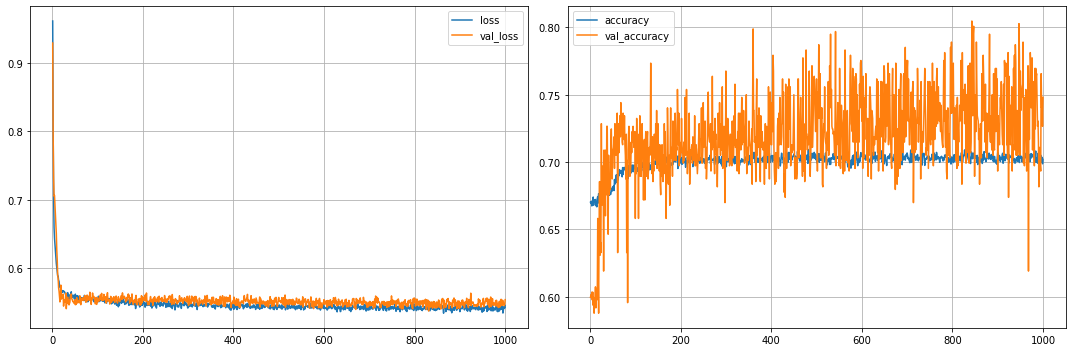

140/140 [==============================] - 3s 17ms/step - loss: 0.5455 - accuracy: 0.7020 - val_loss: 0.5540 - val_accuracy: 0.7480


NameError: name 'pickle' is not defined

In [11]:
history = model.fit(
    train_datagen,
    epochs=1000,
    steps_per_epoch=len(train_datagen) // 4,
    validation_data=val_datagen,
    validation_steps=len(val_datagen),
    shuffle=False,
    callbacks = callback,
    use_multiprocessing=True,
    workers=4
) 
# save history to disk
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
plt.figure(figsize = (15,7))

tr_losses = history.history['loss']
val_losses = history.history['val_loss']

tr_accs = history.history['accuracy']
val_accs = history.history['val_accuracy']

plt.plot(tr_losses, label = "train_loss")
plt.plot(val_losses, label = "val_loss")
plt.ylim(0.52, 0.56)
plt.xlabel("Number of epochs")
plt.ylabel("Cost (J)")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize = (15,7))

plt.plot(tr_accs, label = "acc_train")
plt.plot(val_accs, label = "acc_val")
plt.xlabel("Number of epochs")
# plt.xlim(0, 1000)
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()

697/697 [==============================] - 1s 1ms/step
[[0.1428269  0.8571731 ]
 [0.00295965 0.99704033]
 [0.580567   0.41943303]
 ...
 [0.57679313 0.42320693]
 [0.5970938  0.40290618]
 [0.00172906 0.998271  ]]


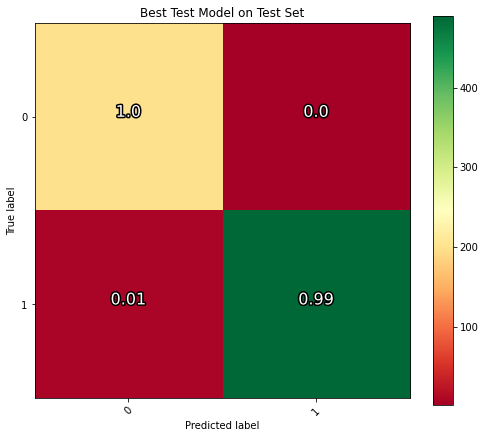

559/559 [==============================] - 1s 1ms/step
[[0.01 0.99]
 [0.44 0.56]
 [0.51 0.49]
 ...
 [0.38 0.62]
 [0.52 0.48]
 [0.23 0.77]]


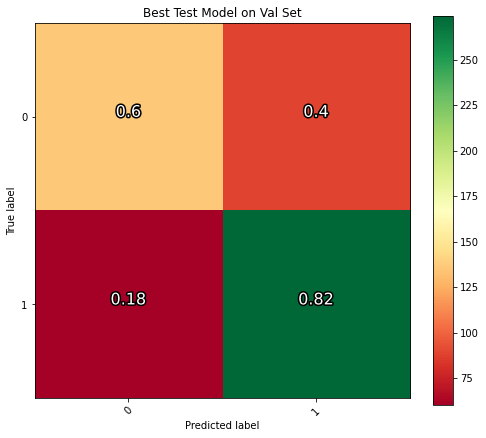

697/697 [==============================] - 1s 1ms/step
[[0.47 0.53]
 [0.01 0.99]
 [0.6  0.4 ]
 ...
 [0.59 0.41]
 [0.62 0.38]
 [0.01 0.99]]


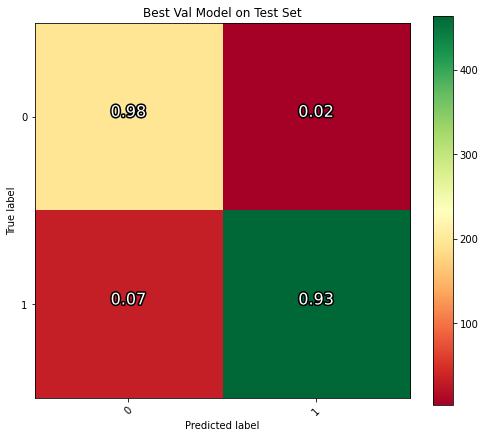

559/559 [==============================] - 1s 1ms/step
[[0.06 0.94]
 [0.6  0.4 ]
 [0.52 0.48]
 ...
 [0.37 0.63]
 [0.51 0.49]
 [0.37 0.63]]


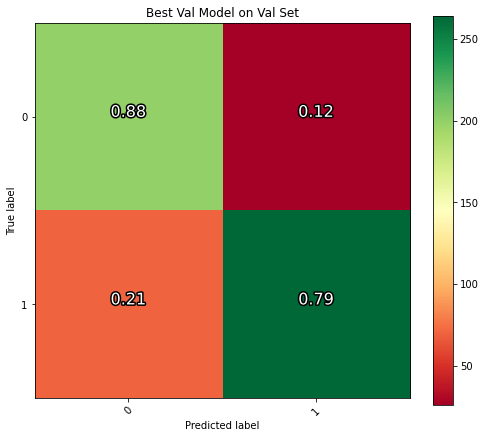

In [18]:
test_model = tf.keras.models.load_model('prettygoodtest.h5')
val_model = tf.keras.models.load_model('prettygoodval.h5')
# epoch_model = tf.keras.models.load_model('model_saves/model00100.h5')

import matplotlib.patheffects as PathEffects
import itertools
def plot_confusion_matrix(cm, classes, normalise = False, title = 'Confusion matrix', cmap = plt.cm.RdYlGn):
    
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalise:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        cm = cm.round(2)

    thresh = cm.max() / 1.1
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        txt =  plt.text(
            j, i, cm[i, j],
            horizontalalignment = "center",
            color = "white",
            size = 16
        )
        txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='black')])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

val_datagen = DataGenerator(
    partition["val"],
    labels,
    dataset_dir=val_datapath,
    # batch_size=BATCH_SIZE,
    batch_size=1,
    shuffle=False,
    **params
)

def graph_predictions(model, datagen, classes, title): 
    predictions = model.predict(
        datagen,
        verbose = 1,
    )
    print(predictions)
    predictions.squeeze().argmax(axis = -1)
    classification__report = classification_report(
        classes, 
        predictions.squeeze().argmax(axis = 1)
    )
    confusion__matrix = confusion_matrix(
        classes,
        predictions.squeeze().argmax(axis = 1)
    )
    np.set_printoptions(precision = 2)
    fig2 = plt.figure(figsize = (7,6))
    plot_confusion_matrix(
        confusion__matrix,
        classes = np.unique(classes),
        normalise = True,
        title = title
    )
    plt.show()

graph_predictions(test_model, test_datagen, classes,  "Best Test Model on Test Set")
graph_predictions(test_model, val_datagen, val_classes, "Best Test Model on Val Set")
graph_predictions(val_model, test_datagen, classes,  "Best Val Model on Test Set")
graph_predictions(val_model, val_datagen, val_classes, "Best Val Model on Val Set")
# DONT FORGET TO CHANGE WHICH MODEL YOU'RE LOADING